# Visual Banana

https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md

TO DO 
- Prioritized Experience Replay 
- Check if grayscale images are OK
- Due

## Setup

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from tqdm import tnrange, tqdm_notebook
%matplotlib inline
from badaii import helpers
from PIL import Image

## Agent

Either using the library or the agent code below.

In [2]:
%load_ext autoreload
%autoreload 2

from badaii.rl.agents.double_dqn import Agent

In [ ]:
from badaii.rl.agents.replay_buffer import ReplayBuffer
from badaii.moving_result import MovingResult

class Agent():
    """Double DQN Agent with epsilon-greedy policy 
    
    Parameters
    ----------
    seed: int 
        Number for random seeding
    replay_size: int
        Size of the experience replay buffer
    batch_size: int
        Size of the batch used when learning
    gamma: float
        Discount rate
    lrate: int or float
        Learning rate 
    tau: float
        Soft target update rate
    """
    def __init__(self, model=None, model_target=None, action_size=None, seed=None,
                 replay_size = 100000, batch_size=64, update_frequency=4,
                 gamma=0.99, lrate=5e-4, tau=0.001, restore=None):
        if restore is not None:
            checkpoint = torch.load(restore)
            
        self.update_frequency = update_frequency if not restore else checkpoint['update_frequency']
        self.seed = seed if not restore else checkpoint['seed']
        self.action_size = action_size if not restore else checkpoint['action_size']
        self.replay_size = replay_size if not restore else checkpoint['replay_size']
        self.batch_size = batch_size if not restore else checkpoint['batch_size']
        self.gamma = gamma if not restore else checkpoint['gamma']
        self.lrate = lrate if not restore else checkpoint['lrate']
        self.tau = tau if not restore else checkpoint['tau']
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        if not restore:
            self.memory = ReplayBuffer(
                self.action_size, self.replay_size, self.batch_size, self.seed, self.device
                )
        else:
            self.memory = checkpoint['memory']

        self.q_network = model.to(self.device)
        self.q_network_target = model_target.to(self.device)
        
        if restore is not None:
            self.q_network.load_state_dict(checkpoint['state_dict'])
            self.q_network_target.load_state_dict(checkpoint['state_dict'])

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.lrate)
        
        self.losses = MovingResult(100, name='loss', save_raw=False)
        self.reset_episode()
        
    def save(self, filename, memory=False, params=None):
        checkpoint = self.params
        if not memory:
            checkpoint['memory'] = None 
        if params is not None:
            for k,v in params.items():
                checkpoint[k] = v
        checkpoint['state_dict'] = self.q_network.state_dict()
        torch.save(checkpoint, filename)

    def sample(self):
        return np.random.randint(self.action_size)
        
    def reset(self):
        self.memory = ReplayBuffer(self.action_size, self.replay_size, self.batch_size, self.seed, self.device)
        self.losses = MovingResult(100, name='loss', save_raw=False)
        self.reset_episode()

    def reset_episode(self):
        self.it = 0
    
    def step(self, state, action, reward, next_state, done, train=True):
        self.memory.add(state, action, reward, next_state, done)
        self.it += 1 
        if train and self.it % self.update_frequency == 0 and len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)
    
    def act(self, state, epsilon=0.):
        """ Epsilon-Greedy policy
        
        """
        probs = epsilon * np.ones(self.action_size) / self.action_size
        state = torch.from_numpy(state).float().to(self.device)
        
        self.q_network.eval()
        with torch.no_grad():
            probs[np.argmax(self.q_network(state).cpu().numpy())] += 1-epsilon
        self.q_network.train()
        return np.random.choice(np.arange(self.action_size), p=probs)
    
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        # argmax_a Q^(next_state,a, w)
        with torch.no_grad():
            _ , best_actions = self.q_network(next_states).max(dim=1)
            # y^ = td_target
            # y^ = reward + gamma * Q^(next_state,argmax_a(next_state,a, w), w-), episode not terminal
            # y^ = reward, episode terminal
            td_targets = rewards + self.gamma * torch.gather(self.q_network_target(next_states),1,best_actions.view(-1,1))
            for i in range(self.batch_size):
                if dones[i].item() == 1.0:
                    td_targets[i] = rewards[i]   
        # delta = y^-Q
        # clamp btwn -1..1
        delta = torch.clamp(td_targets-torch.gather(self.q_network(states),1,actions), -1., 1.)
        # loss = sum (y^-Q)^2
        loss = torch.sum(torch.pow(delta,2))
        self.losses.add(loss.item()/self.batch_size)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update()
            
    def soft_update(self):
        """Soft update of target network
        θ_target = τ*θ_local + (1 - τ)*θ_target
        """
        for target_param, param in zip(self.q_network_target.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.tau*param.data+(1-self.tau)*target_param.data)
            
    @property
    def params(self):
        params = {
            'action_size': self.action_size,
            'seed': self.seed,
            'replay_size': self.replay_size,
            'batch_size': self.batch_size,
            'gamma': self.gamma, 
            'lrate': self.lrate,
            'tau': self.tau, 
            'memory': self.memory,
            'update_frequency': self.update_frequency
        }
        return params

## Environment

In [3]:
env = UnityEnvironment(file_name="data/VisualBanana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

Number of agents: 1
Number of actions: 4
States look like:


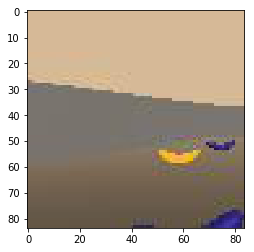

States have shape: (1, 84, 84, 3)


In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations[0]
print('States look like:')
plt.imshow(np.squeeze(state))
plt.show()
state_size = state.shape
print('States have shape:', state.shape)

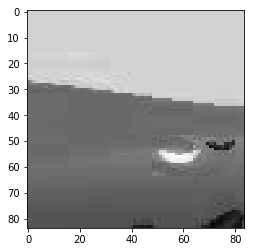

In [6]:
# gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
plt.imshow(0.2989 * state[0,:,:,0] + 0.5870 * state[0,:,:,0] + 0.1140 * state[0,:,:,0], cmap='gray')
plt.show()

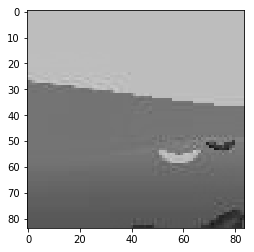

In [7]:
from PIL import Image
im = Image.fromarray(np.uint8(state[0]*255), 'RGB')
im_gray = im.convert('L')
plt.imshow(im_gray, cmap='gray')
plt.show()

In [8]:
np.array(im_gray).shape

(84, 84)

## Play Random Game
Watch an agent play randomly

In [ ]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.visual_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.visual_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

## Helpers

In [8]:
def preprocess(state_rgb):
    im = Image.fromarray(np.uint8(state_rgb*255).reshape(84,84,3), 'RGB')
    im_gray = im.convert('L')
    a = np.array(im_gray)
    return a.reshape(1, 1, a.shape[0],a.shape[1]) / 255.0

In [9]:
def reset_env(env, brain_name, train_mode=True):
    env_info = env.reset(train_mode=train_mode)[brain_name]
    state = env_info.visual_observations[0].reshape(1,3,84,84)
    return preprocess(state[0])

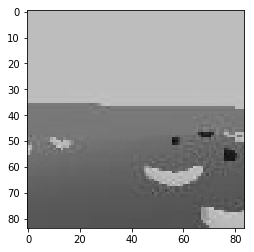

(1, 1, 84, 84)

In [11]:
s = reset_env(env, brain_name)
plt.imshow(Image.fromarray(np.uint8(s[0,0]*255), 'L'))
plt.show()
s.shape

In [12]:
def step_env(env, brain_name, action):
    env_info = env.step(action)[brain_name] 
    next_state = env_info.visual_observations[0].reshape(1,3,84,84)
    next_state = preprocess(next_state[0])
    reward = env_info.rewards[0] 
    done = env_info.local_done[0]
    return (next_state, reward, done)

In [13]:
def init_replay_memory(agent, env, brain_name, size, steps = 2000, action_repeat=4):
    it = 0 
    while it < size: 
        state = reset_env(env, brain_name)
        for step_i in range(steps):
            action = agent.sample()
            
            reward = 0 
            for _ in range(action_repeat):
                next_state, r, done = step_env(env, brain_name, action)
                reward += r
            agent.step(state, action, reward, next_state, done, train=False)
            
            it += 1 
            state = next_state
            
            if it >= size or done: 
                break

In [14]:
class QMetric():
    def __init__(self, states, model):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.states = torch.from_numpy(states).float().to(self.device).detach()
        self.model = model 
        
    def evaluate(self):
        with torch.no_grad():
            m, _ = torch.max(self.model(self.states), dim=1)
            return torch.mean(m)

In [15]:
def define_Q_metric(env, brain_name, num_states, model):
    states = np.zeros((100, 1, 84, 84))
    metric = QMetric(states, model)
    _ = reset_env(env, brain_name)
    for i in range(100):
        action = np.random.randint(action_size)
        for _ in range(4):
            state, reward, done = step_env(env, brain_name, action)
        states[i] = state
        if done:
            _ = reset_env(env, brain_name)
    return metric

In [ ]:
metric = define_Q_metric(env, brain_name, 100, m )

In [167]:
metric.evaluate()

tensor(0.0284)

In [16]:
def evaluate_policy(env, brain_name, agent, episodes=100, eps=0.05):
    scores = []
    for i in range(episodes):
        score = 0 
        state = reset_env(env, brain_name)
        for step_i in range(2000):
            action = agent.act(state, epsilon=eps)
            for _ in range(4):
                state, reward, done = step_env(env, brain_name, action)
                score += reward
            if done: 
                break
        scores.append(score)
    return np.mean(scores)

In [ ]:
evaluate_policy(env, brain_name, agent, episodes=10)

## Agent

- 32 8x8 filters with stride 4 _ Relu
- 64 4x4 filters with stride 2 - ReLu
- 64 3x3 filters with stride 1 - ReLu 
- Fully Connected Layer with 1024 units - ReLu
- Fully Connected Layer with # of actions units

In [17]:
class QNetwork(nn.Module):
    def __init__(self, state_channels, action_size, seed):
        """
        
        """
        super(QNetwork, self).__init__()
        torch.manual_seed(seed)
        
        self.state_channels = state_channels
        self.action_size = action_size
        self.seed = seed
        
        # 32 8x8 filters with stride 4
        self.conv1 = nn.Conv2d(state_channels, 32, 8, stride=4)
        # 64 4x4 filters with stride 2 
        self.conv2 = nn.Conv2d(32,64,4, stride=2)
        # 64 3x3 filters with stride 1 
        self.conv3 = nn.Conv2d(64,64,3, stride=1)
        # 64x7x7, 1024
        self.fc1 = nn.Linear(64*7*7, 1024)
        # 1024, action_size
        self.fc2 = nn.Linear(1024, action_size)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.shape[0], -1)))
        x = self.fc2(x)
        return x 

## Train

In [18]:
episodes = 100
steps = 2000
out_file='model_v1.ckpt'
print_every = 1

# Hyperparameters

action_repeat = 4
update_frequency = 4

gamma = 0.99
batch_size = 32
learning_rate = 2.5e-4
tau = 0.05

replay_memory_size = int(1.0e5)
replay_start_size = replay_memory_size / 20

initial_eps = 1.0
final_eps = 0.1 
final_exp_it = 2.0e5

In [19]:
m = QNetwork(1,action_size,0)
m_target = QNetwork(1, action_size, 0)

agent = Agent(m, m_target, action_size=4, seed=0,
              batch_size=batch_size,
              gamma = gamma, 
              update_frequency = update_frequency,
              lrate = learning_rate,
              replay_size = replay_memory_size, 
              tau = tau
             )

In [ ]:
agent.reset()
scores = []

last_saved = 0 
eps = initial_eps
it = 0

# define q metric
# 100 random state
q_metric = define_Q_metric(env, brain_name, 100, m)
qs = []

# fill replay memory 
init_replay_memory(agent, env, brain_name, replay_start_size, steps = 2000)

with tnrange(episodes) as t: 
    for ep_i in t: 
        agent.reset_episode()
        state = reset_env(env, brain_name)
        for step_i in range(steps):
            action = agent.act(state, epsilon=eps)

            # action repeat
            reward =0
            for i in range(action_repeat):
                next_state, r, done = step_env(env, brain_name, action)
                reward += r

            # step agent   
            agent.step(state, action, reward, next_state, done)
            state = next_state
            if done: 
                break 
            
            # decay epsilon each it 
            it += 1 
            eps = max(final_eps,initial_eps-(initial_eps-final_eps)/final_exp_it*it)
        
        # calculate q metric 
        qs.append(q_metric.evaluate())
        
        # update log
        if (ep_i+1) % print_every == 0:
            score = evaluate_policy(env, brain_name, agent, episodes=10)
            scores.append((ep_i+1, score))
            t.set_postfix(
                it=it, 
                epsilon=eps, 
                score=f'{score:.2f}'
            )
            
        if scores[-1][1] >= 5.0 and scores[-1][1] > last_saved*1.05:
            last_saved = scores[-1][1]
            print('Saving...')
            agent.save(out_file)

[]

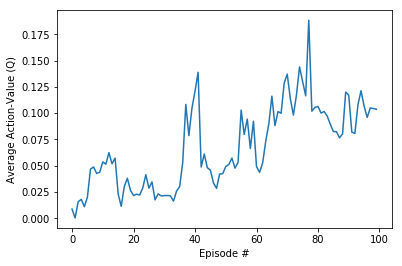

In [186]:
plt.plot(np.arange(episodes), qs)
plt.xlabel('Episode #')
plt.ylabel('Average Action-Value (Q)')
plt.plot()

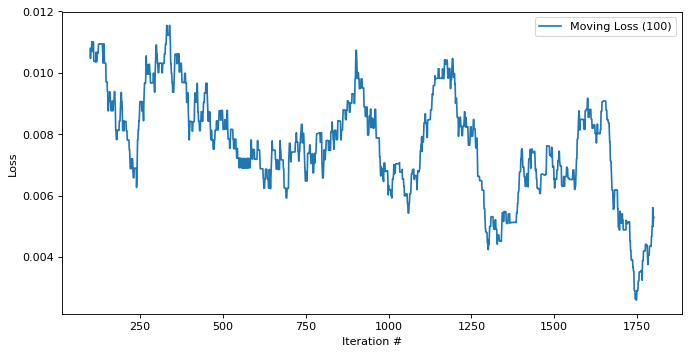

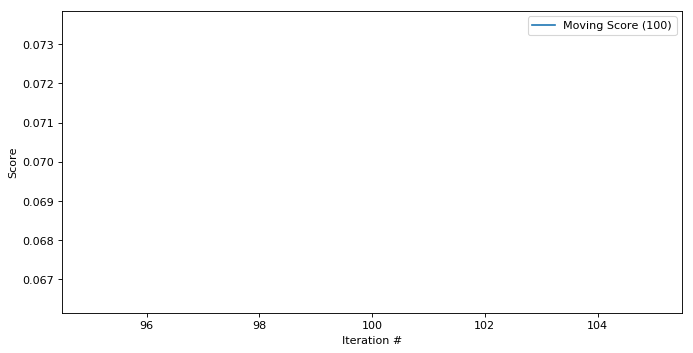

In [187]:
agent.losses.plot()

In [ ]:
p = {
    'it': it,
    'eps': eps
}
agent.save('09-10-2018-01.ckpt', params=p)